# PyZX interoperability: How to use Topologiq with PyZX graphs

In [16]:
import os
import sys
import pyzx as zx

from topologiq.scripts.runner import runner
from topologiq.utils.interop_pyzx import pyzx_g_to_simple_g
from topologiq.utils.utils_zx_graphs import kind_to_zx_type

repo_root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

zx.settings.colors = zx.rgb_colors

# Uncomment line below to enable interactive 3D visuals, but bear in mind it will ask you to approve a download.
# %matplotlib widget

This notebook offers an example of how to use ***topologiq*** to perform an algorithmic lattice surgery of a simple PyZX graph.

## Input: PyZX graph

We'll use a simple PyZX graph for this notebook, consisting of three CNOTs.

The process is the same for any graph, irrespective of size.

Having said that, be careful with randomly generated graphs. PyZX random graphs sometimes have disconnected subgraphs, i.e., which are incompatible with Topologiq. And remember that, for the time being, Topologiq only supports X and Z spiders, as well as Hadamard edges.

In [17]:
circuit_name = "pyzx_jupyter_cnots"

c = zx.Circuit(2)
c.add_gate("CNOT", 0, 1)
c.add_gate("CNOT", 1, 0)
c.add_gate("CNOT", 1, 0)

pyzx_graph = c.to_graph()
zx.draw(pyzx_graph, labels=True)

# Save Matplotlib figure to use in later operations
fig_data = zx.draw_matplotlib(pyzx_graph, labels=True)

## Process: Topologiq

PyZX graphs have information that Topologiq doesn't need. So, we'll start by distilling the PyZX graph into a `simple_graph`.

The corresponding operation applies the following transformations:
- Dump the entire PyZX graph into a dictionary using PyZX internal methods,
- Transform into a dictionary with clear syntax for 3D positioning but all values zeroed out,
- Distill the 3D dictionary into a simpler dictionary for consumption by the algorithm.

In [18]:
simple_graph = pyzx_g_to_simple_g(pyzx_graph)
print(simple_graph)

{'nodes': [(0, 'O'), (1, 'O'), (2, 'X'), (3, 'Z'), (4, 'X'), (5, 'Z'), (6, 'X'), (7, 'Z'), (8, 'O'), (9, 'O')], 'edges': [((0, 3), 'SIMPLE'), ((1, 2), 'SIMPLE'), ((2, 3), 'SIMPLE'), ((2, 5), 'SIMPLE'), ((3, 4), 'SIMPLE'), ((4, 5), 'SIMPLE'), ((4, 6), 'SIMPLE'), ((5, 7), 'SIMPLE'), ((6, 7), 'SIMPLE'), ((6, 8), 'SIMPLE'), ((7, 9), 'SIMPLE')]}


The next step is to feed the `simple_graph` to ***topologiq*** and let it do its thing. In short, ***topologiq*** will traverse that graph using a Breadth-First Search (BFS) and exchange spiders and legs in the original ZX graph for a 3D equivalent object: a cube for spiders, a pipe for legs/deges. 

If/when the lattice surgery is complete, ***topologiq*** will produce:
- text results saved to `[root]/output/txt/` that includes the final surgery/space-time diagram,
- and related objects for programmatic use.

Visualisations are possible, but significantly slow things down. Check ***topologiq***'s [README](../../README.md) for details.

> Ps. **Topologiq** is deterministic given the choice of first spider/cube. In other words, once a starting point has been defined, the result will always be the same. Having said that, the first spider/cube is chosen randomly from a list with the graph's most central spiders. As such, there is a finite but still multiple number of possible outputs. In the block below, we have purposely ommited determining the seed so you can observe the range of possible outcomes by running it several times.

.
SUCCESS!!! Volume: 14. Duration: 0.09s (attempt), 0.09s (total).
Visualisations enabled. For faster runtimes, disable visualisations.


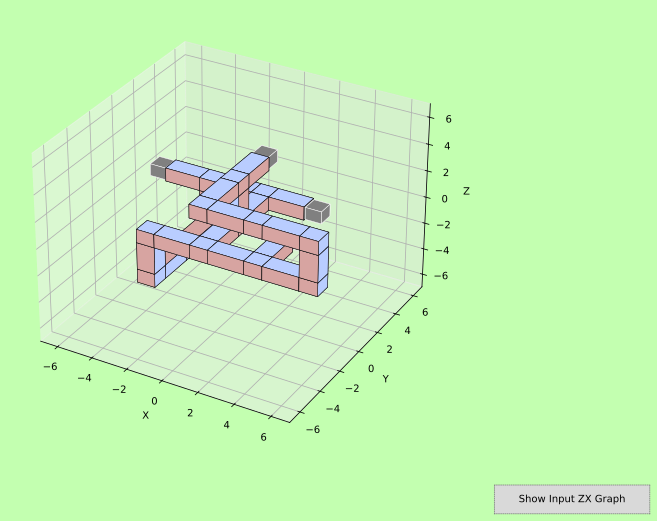

In [19]:
# Define weights for the value function to to choose best of several valid paths per edge:
# - A negative value for length of path favours short paths.
# - A negative value for number of beams broken by path favours placements that do not block potential open faces requiring connections.
VALUE_FUNCTION_HYPERPARAMS = (-1, -1)

# Define a desired length of beams
# The beams clear the paths in/out of spiders/cubes needing connections.
# Beams are theoretically infinite in length, but since computers struggle with infinity, they need to be given an explicit lenght. 
# For small graphs, 9 is plenty.
LENGTH_OF_BEAMS = 9

kwargs = {
    "weights": VALUE_FUNCTION_HYPERPARAMS,
    "length_of_beams": LENGTH_OF_BEAMS,
}

# Run Topolgiq
simple_graph_after_use, edge_paths, lattice_nodes, lattice_edges = runner(
    simple_graph,
    circuit_name,
    max_attempts=10,
    vis_options=("final", None),
    fig_data=fig_data,  # Use the fig_data from PyZX, to overlay input ZX graph over output visuals.
    **kwargs
)

## Output: Understanding outputs

Topologiq returns four objects:
- `simple_graph_after_use`: the original `simple_graph`, returned for convenience.
- `edge_paths`: a set of 3D edges where each edge corresponds to the original edges in the ZX graph but where the "nodes" have been exchanged for all 3D blocks and pipes needed to clear the edge in a 3D space (contains redundant nodes across edges).
- `lattice_nodes`: all nodes in `edge_paths` distilled into a single lattice surgery / space-time diagram object.
- `lattice_edges`: all edges in `edge_paths` distilled into a single lattice surgery / space-time diagram object.

These objects can be used variously. For instance, with more complex graphs, it is possible to link information some of the information in the original PyZX graph such as, for instance, phases, with the 3D space-time diagram produced by Topologiq.

Having said that, since the circuit in this notebook is very simple, we will now limit ourselves to understanding the pure outputs.

In [20]:
zx.draw(pyzx_graph, labels=True)

if edge_paths:
    for key, edge in edge_paths.items():
        block_by_block = []
        nodes_and_edges = []
        for node in edge["path_nodes"]:
            block_by_block.append(node[1])
            nodes_and_edges.append(kind_to_zx_type(node[1]))
        print(f"{key}: {'-'.join(block_by_block)} ({' - '.join(nodes_and_edges)})")

(3, 4): xzz-xoz-xxz (X - SIMPLE - Z)
(4, 5): xzz-xoz-xxz (X - SIMPLE - Z)
(4, 6): xzz-xzo-xzz (X - SIMPLE - X)
(0, 3): xxz-oxz-ooo (Z - SIMPLE - BOUNDARY)
(2, 3): xxz-oxz-zxz (Z - SIMPLE - X)
(5, 7): xxz-oxz-xxz (Z - SIMPLE - Z)
(6, 8): xzz-xoz-ooo (X - SIMPLE - BOUNDARY)
(1, 2): zxz-oxz-ooo (X - SIMPLE - BOUNDARY)
(7, 9): xxz-xoz-ooo (Z - SIMPLE - BOUNDARY)
(2, 5): zxz-zxo-zxx-zox-zzx-zox-zxx-zxo-zxz-oxz-xxz (X - SIMPLE - Z - SIMPLE - X - SIMPLE - Z - SIMPLE - X - SIMPLE - Z)
(6, 7): xzz-xoz-xxz-oxz-xxz-oxz-zxz-zxo-zxz-oxz-xxz (X - SIMPLE - Z - SIMPLE - Z - SIMPLE - X - SIMPLE - X - SIMPLE - Z)
